## Pre-Task: Describe the goals of your study

Scenario involves working as a data scientist with a research firm that specializes in emergency management. To show off the firm's capabilities in disaster analysis, logistic regression model will be created and trained. The model will use the 1912 titanic disaster dataset, which is stored on a remote database.

In this analysis, select features will be used to determine the probability whether a passenger survived or not survived. Logistic and KNN will be used, and GridsearchCV will be used to determine optimal parameters for both.


- What are we looking for? What is the hypothesis?
- How can we train the model?
- What is the overall goal of this research project?

In [1059]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import patsy
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score,roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import BaggingClassifier
%matplotlib inline

## Part 1: Aquire the Data

In [26]:
#psql -h dsi.c20gkj5cvu3l.us-east-1.rds.amazonaws.com -p 5432 -U dsi_student titanic
#password: gastudents

#### 1. Connect to the remote database

Using psycopg, we can connect to the AWS remote database.

In [549]:
import psycopg2
params = {
  'dbname': 'titanic',
  'user': 'dsi_student',
  'password': 'gastudents',
  'host': 'dsi.c20gkj5cvu3l.us-east-1.rds.amazonaws.com',
  'port': 5432
}

conn = psycopg2.connect(**params)
c = conn.cursor()

#### 2. Query the database and aggregate the data


Using psycopg2, the remote connection was established, and selecting all rows, all columns from the train table in the titanic database. The data and column names were set to records and colnames, respectively, and then loaded into a dataframe called train


VARIABLE DESCRIPTIONS:

survival:        Survival
                (0 = No; 1 = Yes)

pclass:          Passenger Class
                (1 = 1st; 2 = 2nd; 3 = 3rd)

name:            Name

sex:             Sex

age:             Age

sibsp:           Number of Siblings/Spouses Aboard

parch:           Number of Parents/Children Aboard

ticket:          Ticket Number

fare:            Passenger Fare

cabin:           Cabin

embarked:        Port of Embarkation
                (C = Cherbourg; Q = Queenstown; S = Southampton)
                
                
Will try to use all features to predict survival rate


In [70]:
c.execute("SELECT * FROM train;");
records = c.fetchall()
colnames = [desc[0] for desc in c.description]

train = pd.DataFrame(records,columns = colnames)
del train['index']
train.head()
train.to_csv('Titanic_train.csv')

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500  None        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250  None        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500  None        S

In [75]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [81]:
#There are a lot of distinct values of cabin, so it might be difficult to gauge the correlation
train['Cabin'].unique()

array([None, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35', 'C87',
       'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19', 'B49', 'D',
       'C22 C26', 'C106', 'C65', 'E36', 'C54', 'B57 B59 B63 B66', 'C7',
       'E34', 'C32', 'B18', 'C124', 'C91', 'E40', 'T', 'C128', 'D37',
       'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44', 'A34', 'C104', 'C111',
       'C92', 'E38', 'D21', 'E12', 'E63', 'A14', 'B37', 'C30', 'D20',
       'B79', 'E25', 'D46', 'B73', 'C95', 'B38', 'B39', 'B22', 'C86',
       'C70', 'A16', 'C101', 'C68', 'A10', 'E68', 'B41', 'A20', 'D19',
       'D50', 'D9', 'A23', 'B50', 'A26', 'D48', 'E58', 'C126', 'B71',
       'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63', 'C62 C64', 'E24'

#### 5. What are the risks and assumptions of our data? 
1) There is missing data for Age and Cabin

2) Is there a relationship between a person and whether he/she had a parent/child on board


## Part 2: Exploratory Data Analysis

#### 1. Describe the Data

In [82]:
train.describe()

PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000         NaN    0.000000   
50%     446.000000    0.000000    3.000000         NaN    0.000000   
75%     668.500000    1.000000    3.000000         NaN    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200

Survived, SibSp (Siblings), Parch (number of parent or children aboard), and Fare are all skewed, given that one standard deviation less than the mean is negative.

In [83]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Dropping observations where Age is missing and Fares are 0, such that the former can be included in the model, and the latter can be log-normalized

In [291]:
train_df = train[(train['Age'].notnull()) & train['Fare'] != 0]
train_df.describe()

PassengerId    Survived      Pclass         Age       SibSp  \
count   707.000000  707.000000  707.000000  707.000000  707.000000   
mean    448.431400    0.408769    2.237624   29.645219    0.517680   
std     259.175341    0.491955    0.836558   14.558872    0.932972   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     221.500000    0.000000    1.000000   20.000000    0.000000   
50%     446.000000    0.000000    2.000000   28.000000    0.000000   
75%     677.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    5.000000   

            Parch        Fare  
count  707.000000  707.000000  
mean     0.435644   35.038024  
std      0.856422   53.067186  
min      0.000000    4.012500  
25%      0.000000    8.050000  
50%      0.000000   15.850000  
75%      1.000000   34.197900  
max      6.000000  512.329200

In [147]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    714 non-null int64
Survived       714 non-null int64
Pclass         714 non-null int64
Name           714 non-null object
Sex            714 non-null object
Age            714 non-null float64
SibSp          714 non-null int64
Parch          714 non-null int64
Ticket         714 non-null object
Fare           714 non-null float64
Cabin          185 non-null object
Embarked       712 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 72.5+ KB


In [1209]:
# relationship with passenger class and female show 
#that females in higher passenger class survived at a higher percentage
#males fared worse than females, especially in class 3

sex_pclass = train_df.groupby(['Sex','Pclass'])['Survived'].agg({sum,len})
sex_pclass['pct'] = (sex_pclass['sum'] / sex_pclass['len']).astype(float)
sex_pclass

sum  len       pct
Sex    Pclass                    
female 1        82   85  0.964706
       2        68   74  0.918919
       3        47  102  0.460784
male   1        40   98  0.408163
       2        15   99  0.151515
       3        37  249  0.148594

In [983]:
train_df['Cabin'].unique()

array([None, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'D33', 'B30', 'B28', 'C83', 'F33', 'F G73', 'E31',
       'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101', 'D47', 'B86',
       'F2', 'C2', 'B19', 'A7', 'C49', 'F4', 'B4', 'B80', 'A31', 'D36',
       'D15', 'C93', 'C78', 'D35', 'C87', 'B77', 'E67', 'C125', 'C99',
       'C118', 'D7', 'B49', 'D', 'C22 C26', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'E33', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'C52',
       'E44', 'A34', 'C104', 'C111', 'C92', 'E38', 'E12', 'E63', 'B37',
       'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'B38', 'B39', 'B22',
       'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68', 'B41', 'A20',
       'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48', 'E58', 'B71',
       'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63', 'C62 C64', 'E24', 'C90',
       'C126', 'C45', 'E8', 'B101', 'C46', 'D30', 'E121', 'D11', 'E77',
       '

In [1187]:
train_df[train_df['SibSp'] != 0]

PassengerId  Survived  Dead  Pclass  \
0              1         0     1       3   
1              2         1     0       1   
3              4         1     0       1   
7              8         0     1       3   
9             10         1     0       2   
10            11         1     0       3   
13            14         0     1       3   
16            17         0     1       3   
18            19         0     1       3   
24            25         0     1       3   
25            26         1     0       3   
27            28         0     1       1   
34            35         0     1       1   
35            36         0     1       1   
38            39         0     1       3   
39            40         1     0       3   
40            41         0     1       3   
41            42         0     1       2   
43            44         1     0       2   
49            50         0     1       3   
50            51         0     1       3   
52            53         1     0       1   
53            54         1     0       2   
58            59         1     0       2   
59            60         0     1       3   
62            63         0     1       1   
63            64         0     1       3   
68            69         1     0       3   
69            70         0     1       3   
71            72         0     1       3   
..           ...       ...   ...     ...   
754          755         1     0       2   
755          756         1     0       2   
763          764         1     0       1   
765          766         1     0       1   
774          775         1     0       2   
781          782         1     0       1   
787          788         0     1       3   
788          789         1     0       3   
799          800         0     1       3   
801          802         1     0       2   
802          803         1     0       1   
809          810         1     0       1   
813          814         0     1       3   
817          818         0     1       2   
819          820         0     1       3   
820          821         1     0       1   
824          825         0     1       3   
830          831         1     0       3   
831          832         1     0       2   
835          836         1     0       1   
850          851         0     1       3   
852          853         0     1       3   
854          855         0     1       2   
856          857         1     0       1   
860          861         0     1       3   
861          862         0     1       2   
866          867         1     0       2   
869          870         1     0       3   
871          872         1     0       1   
874          875         1     0       2   

                                                  Name     Sex    Age  SibSp  \
0                              Braund, Mr. Owen Harris    male  22.00      1   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.00      1   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.00      1   
7                       Palsson, Master. Gosta Leonard    male   2.00      3   
9                  Nasser, Mrs. Nicholas (Adele Achem)  female  14.00      1   
10                     Sandstrom, Miss. Marguerite Rut  female   4.00      1   
13                         Andersson, Mr. Anders Johan    male  39.00      1   
16                                Rice, Master. Eugene    male   2.00      4   
18   Vander Planke, Mrs. Julius (Emelia Maria Vande...  female  31.00      1   
24                       Palsson, Miss. Torborg Danira  female   8.00      3   
25   Asplund, Mrs. Carl Oscar (Selma Augusta Emilia...  female  38.00      1   
27                      Fortune, Mr. Charles Alexander    male  19.00      3   
34                             Meyer, Mr. Edgar Joseph    male  28.00      1   
35                      Holverson, Mr. Alexander Oskar    male  42.00      1   
38                  Vander Planke, Miss. Augusta Maria  female  18.00      2

In [984]:
train_df.groupby(['Survived','Embarked'])['Age'].count().to_frame()

Age
Survived Embarked     
0        C          51
         Q          20
         S         347
1        C          79
         Q           8
         S         200

#### 2. Visualize the Data

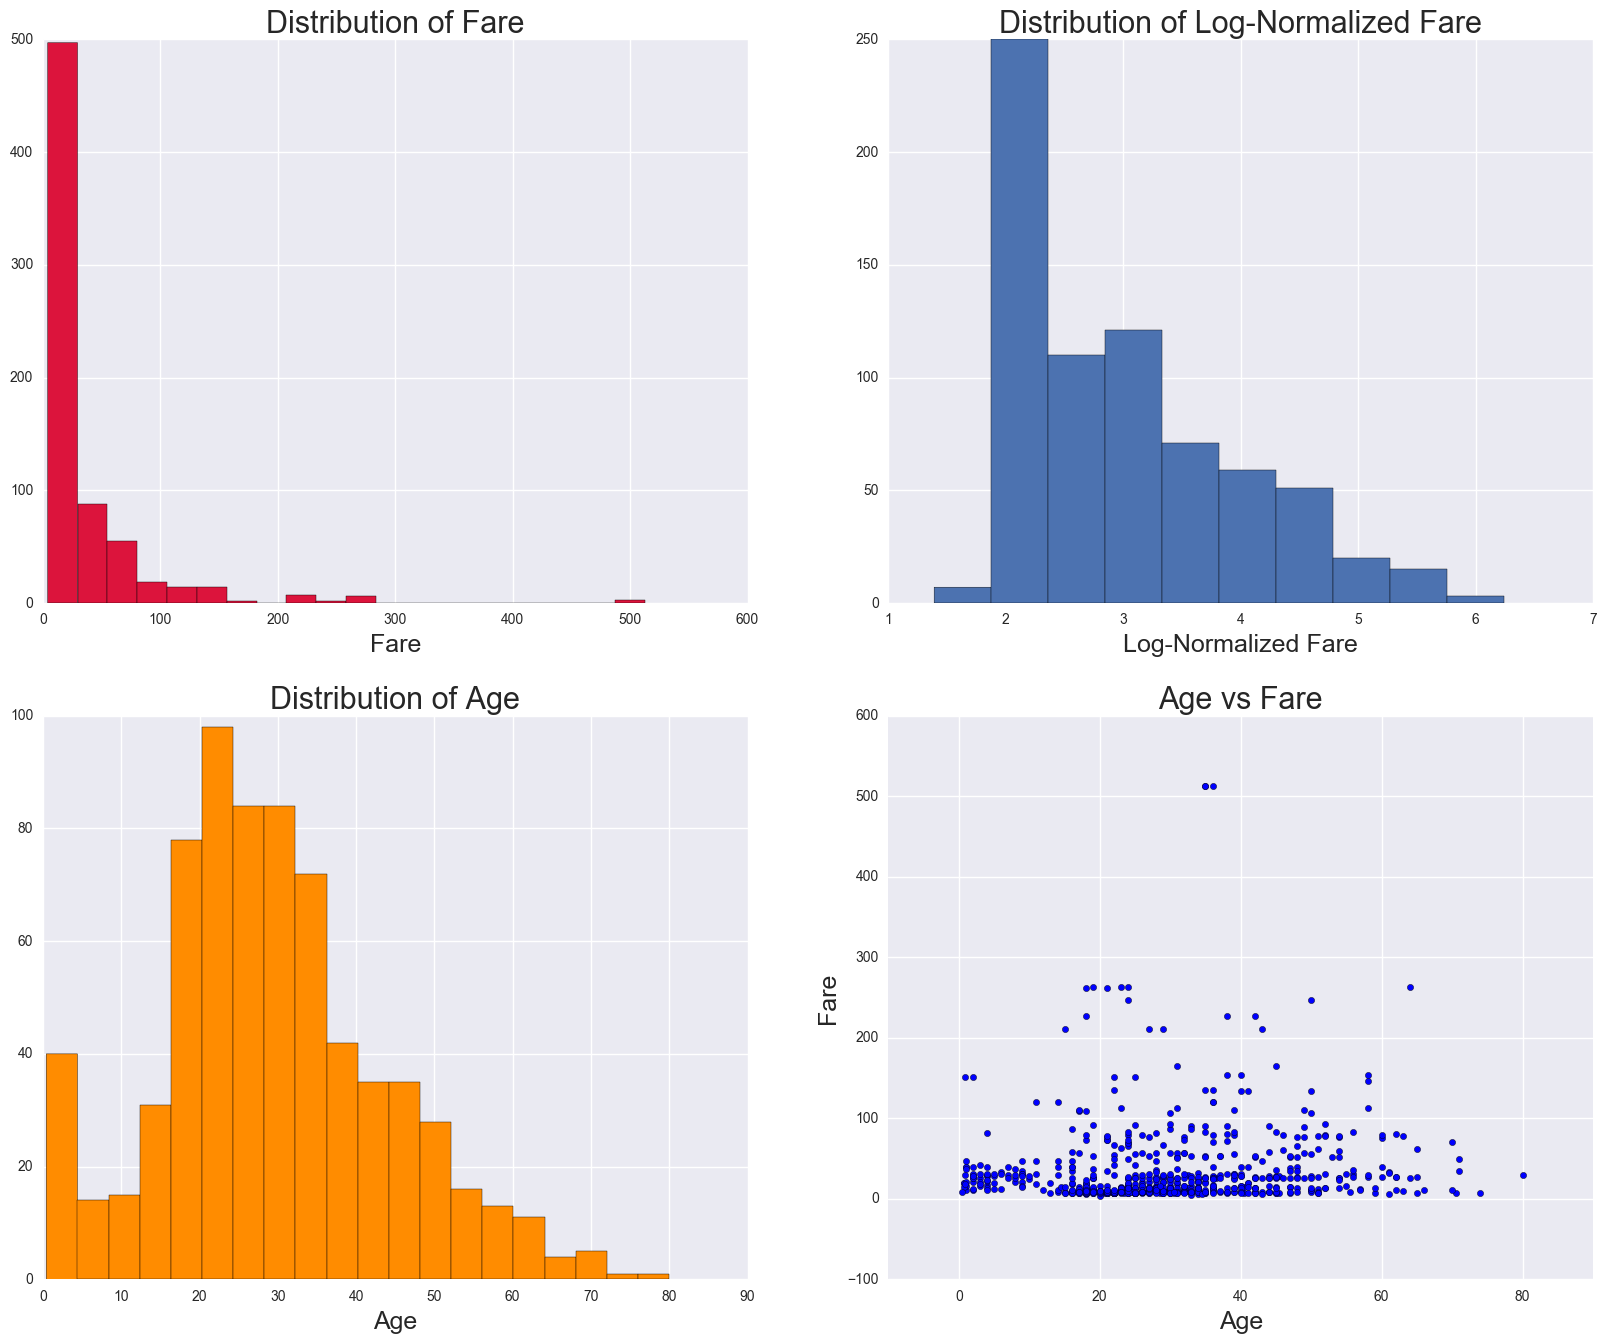

In [508]:
fig, axes = plt.subplots(2,2, figsize=(20,16))

axes[0][0].hist(x = train_df['Fare'],bins = 20,color = 'crimson') 
axes[0][0].set_title('Distribution of Fare',fontsize = 22)
axes[0][0].set_xlabel('Fare',fontsize = 18);

axes[0][1].hist(x = np.log(train_df['Fare']))
axes[0][1].set_title('Distribution of Log-Normalized Fare',fontsize = 22)
axes[0][1].set_xlabel('Log-Normalized Fare',fontsize = 18)


axes[1][0].hist(x = train_df['Age'],bins = 20,color = 'darkorange') 
axes[1][0].set_title('Distribution of Age',fontsize = 22)
axes[1][0].set_xlabel('Age',fontsize = 18)

axes[1][1].scatter('Age','Fare',data = train_df)
axes[1][1].set_title('Age vs Fare',fontsize = 22)
axes[1][1].set_xlabel('Age',fontsize = 18)
axes[1][1].set_ylabel('Fare',fontsize = 18);




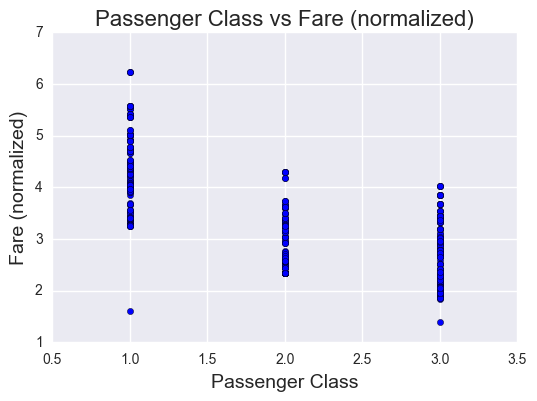

In [1531]:
plt.scatter(x='Pclass',y='Fare_norm',data = train_df)
plt.title('Passenger Class vs Fare (normalized)',fontsize = 16)
plt.xlabel('Passenger Class',fontsize = 14)
plt.ylabel('Fare (normalized)',fontsize = 14);

## Part 3: Data Wrangling

#### 1. Log-Normalize Fare

#### 2. Create Age bins
* Child
* Teenage
* Young Adult
* Adult
* Senior

#### 3. variables to turn into dummies

* Sex
* Passenger Class

#### 4. Other possible bins
* Interaction between having a child/parent and the age
* Interaction between having a child/parent and sex


#### 1. Log-Normalize Fare

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


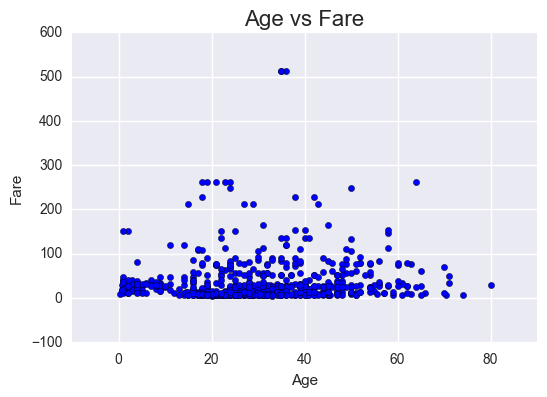

In [1089]:
train_df['Fare_norm'] =  train_df['Fare'].apply(lambda x: np.log(x))
train_df['Age_norm'] =  train_df['Age'].apply(lambda x: np.log(x))

plt.scatter('Age','Fare',data = train_df)
plt.title('Age vs Fare',fontsize = 16)
plt.xlabel('Age')
plt.ylabel('Fare');

#### 2. Create Age bins 

In [1370]:
age_bins = []
for x in train_df['Age']:
    if (x < 13):
        age_bins.append('1-Child')
    elif (x >=13) and (x <=18):
        age_bins.append('2-Teenager')
    elif (x >= 18) and (x < 30):
        age_bins.append('3-Young_adult')
    elif (x >= 30) and (x < 55):
        age_bins.append('4-Adult')
    else:
        age_bins.append('5-Senior')
train_df['Age_bins'] = age_bins

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


#### 3. Create Dummy Variables for *Sex* / patsy matrix

In [1516]:
#dropping some columns that are not needed
features = train_df.drop(axis = 1, labels = ['PassengerId','Name','Ticket','Cabin'])
features.head()

#features = pd.get_dummies(train_df, columns = ['Pclass','Sex','Age_bins'])
f= 'Survived ~ C(Pclass) + C(Sex) + C(Age_bins) + SibSp + Parch + Fare_norm'
y,X = patsy.dmatrices(f, features, return_type='dataframe')



## Part 4: Logistic Regression and Model Validation

In [1512]:
selector = SelectKBest(f_classif,k=10)
selected_data = selector.fit_transform(X, y)
kbest_columns = X.columns[selector.get_support()]
Xbest = pd.DataFrame(selected_data, columns=kbest_columns)
Xbest.head()

C(Pclass)[T.2]  C(Pclass)[T.3]  C(Sex)[T.male]  C(Age_bins)[T.2-Teenager]  \
0             0.0             1.0             1.0                        0.0   
1             0.0             0.0             0.0                        0.0   
2             0.0             1.0             0.0                        0.0   
3             0.0             0.0             0.0                        0.0   
4             0.0             1.0             1.0                        0.0   

   C(Age_bins)[T.3-Young_adult]  C(Age_bins)[T.4-Adult]  \
0                           1.0                     0.0   
1                           0.0                     1.0   
2                           1.0                     0.0   
3                           0.0                     1.0   
4                           0.0                     1.0   

   C(Age_bins)[T.5-Senior]  SibSp  Parch  Fare_norm  
0                      0.0    1.0    0.0   1.981001  
1                      0.0    1.0    0.0   4.266662  
2                      0.0    0.0    0.0   2.070022  
3                      0.0    1.0    0.0   3.972177  
4                      0.0    0.0    0.0   2.085672

#### 1. Define the variables that we will use in our classification analysis

In [1474]:
#feature selection AIC, BIC, r2
#ADD PCLASS-SEX interaction, huge disparity between rich women and others. poor men fared the worst

In [1517]:
#setting the features
X = X.iloc[:,1:]
y = y['Survived'].astype(int)


In [1613]:
X

C(Pclass)[T.2]  C(Pclass)[T.3]  C(Sex)[T.male]  \
0               0.0             1.0             1.0   
1               0.0             0.0             0.0   
2               0.0             1.0             0.0   
3               0.0             0.0             0.0   
4               0.0             1.0             1.0   
6               0.0             0.0             1.0   
7               0.0             1.0             1.0   
8               0.0             1.0             0.0   
9               1.0             0.0             0.0   
10              0.0             1.0             0.0   
11              0.0             0.0             0.0   
12              0.0             1.0             1.0   
13              0.0             1.0             1.0   
14              0.0             1.0             0.0   
15              1.0             0.0             0.0   
16              0.0             1.0             1.0   
18              0.0             1.0             0.0   
20              1.0             0.0             1.0   
21              1.0             0.0             1.0   
22              0.0             1.0             0.0   
23              0.0             0.0             1.0   
24              0.0             1.0             0.0   
25              0.0             1.0             0.0   
27              0.0             0.0             1.0   
30              0.0             0.0             1.0   
33              1.0             0.0             1.0   
34              0.0             0.0             1.0   
35              0.0             0.0             1.0   
37              0.0             1.0             1.0   
38              0.0             1.0             0.0   
..              ...             ...             ...   
856             0.0             0.0             0.0   
857             0.0             0.0             1.0   
858             0.0             1.0             0.0   
860             0.0             1.0             1.0   
861             1.0             0.0             1.0   
862             0.0             0.0             0.0   
864             1.0             0.0             1.0   
865             1.0             0.0             0.0   
866             1.0             0.0             0.0   
867             0.0             0.0             1.0   
869             0.0             1.0             1.0   
870             0.0             1.0             1.0   
871             0.0             0.0             0.0   
872             0.0             0.0             1.0   
873             0.0             1.0             1.0   
874             1.0             0.0             0.0   
875             0.0             1.0             0.0   
876             0.0             1.0             1.0   
877             0.0             1.0             1.0   
879             0.0             0.0             0.0   
880             1.0             0.0             0.0   
881             0.0             1.0             1.0   
882             0.0             1.0             0.0   
883             1.0             0.0             1.0   
884             0.0             1.0             1.0   
885             0.0             1.0             0.0   
886             1.0             0.0             1.0   
887             0.0             0.0             0.0   
889             0.0             0.0             1.0   
890             0.0             1.0             1.0   

     C(Age_bins)[T.2-Teenager]  C(Age_bins)[T.3-Young_adult]  \
0                          0.0                           1.0   
1                          0.0                           0.0   
2                          0.0                           1.0   
3                          0.0                           0.0   
4                          0.0                           0.0   
6                          0.0                           0.0   
7                          0.0                           0.0   
8                          0.0                           1.0   
9                 

#### 2. Transform "Y" into a 1-Dimensional Array for SciKit-Learn

In [1476]:
insert_dead = train_df.columns.get_loc('Survived') + 1
f = lambda x: 1 if x == 0 else 0
dead = train_df['Survived'].apply(f)
#train_df.insert(insert_dead,'Dead',dead)
train_df.head()

PassengerId  Survived  Dead  Pclass  \
0            1         0     1       3   
1            2         1     0       1   
2            3         1     0       3   
3            4         1     0       1   
4            5         0     1       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  Fare_norm       Age_bins  \
0      0         A/5 21171   7.2500  None        S   1.981001  3-Young_adult   
1      0          PC 17599  71.2833   C85        C   4.266662        4-Adult   
2      0  STON/O2. 3101282   7.9250  None        S   2.070022  3-Young_adult   
3      0            113803  53.1000  C123        S   3.972177        4-Adult   
4      0            373450   8.0500  None        S   2.085672        4-Adult   

   Age_norm  
0  3.091042  
1  3.637586  
2  3.258097  
3  3.555348  
4  3.555348

#### 3. Conduct the logistic regression

In [1532]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=77)

In [1533]:
lr = LogisticRegression(random_state=77)
model_lr = lr.fit(X_train,y_train)
ypred_lr = model_lr.predict(X_train)

lr_L1 = LogisticRegression(penalty = 'l1')
model_lrL1 = lr_L1.fit(X_train,y_train)
ypred_lrL1 = model_lrL1.predict(X_train)

print "F1 score for L2:",metrics.f1_score(y_train, ypred_lr)
print "Model score for L2:",model_lr.score(X_train, y_train)
print ''
print "F1 score for L1:",metrics.f1_score(y_train,ypred_lrL1)
print "Model score for L1:",model_lrL1.score(X_train, y_train)

# y_score_L1 = model_lrL1.decision_function(X_train)
# print 'AUC score for L1:',roc_auc_score(y_train,y_score_L1).round(2)



F1 score for L2: 0.738219895288
Model score for L2: 0.788583509514

F1 score for L1: 0.741514360313
Model score for L1: 0.790697674419


#### 4. Examine the coefficients to see our correlations

In [1534]:
col = pd.Series(X.columns).to_frame('col')
coef = []
for x in model_lr.coef_.reshape(len(X.columns),1):
    coef.append(x)
    
coef = pd.Series(coef).to_frame('Coefficients').astype(float)
Coefficients = pd.concat([col,coef],axis = 1)
# Coefficients['Prob'] = Coefficients['Coefficients'].apply(lambda x: (np.exp(x)-1)*100)
# Coefficients.ix[9,'Prob'] = Coefficients.ix[9,'Coefficients']
Coefficients

col  Coefficients
0                C(Pclass)[T.2]     -0.136320
1                C(Pclass)[T.3]     -0.785450
2                C(Sex)[T.male]     -2.372566
3     C(Age_bins)[T.2-Teenager]     -1.140966
4  C(Age_bins)[T.3-Young_adult]     -1.016944
5        C(Age_bins)[T.4-Adult]     -1.108776
6       C(Age_bins)[T.5-Senior]     -1.416375
7                         SibSp     -0.535578
8                         Parch     -0.224248
9                     Fare_norm      0.646483

Pclass: survival rate increases with passenger class, first being the highest (similar to Fare..fare and passenger class is positively correlated

Sex: Males have a lower survival rate than females

Age_bins: younger the person, the odds of surviving increase, except for senior and teenager, which are negatively related with Adults

Siblings and Parent/Child: having family on board have a negative survival odds

#### 6. Test the Model by introducing a *Test* or *Validaton* set 

In [1535]:
#the test set is the X_test, y_test

#### 7. Predict the class labels for the *Test* set

In [1536]:
ypred_lr = model_lr.predict(X_test)
ypred_lrL1 = model_lrL1.predict(X_test)

#### 8. Predict the class probabilities for the *Test* set

In [1537]:
y_pp = pd.DataFrame(model_lr.predict_proba(X_test), columns=['class_0_pp','class_1_pp'])
y_pp_L1 = pd.DataFrame(model_lrL1.predict_proba(X_test), columns=['class_0_pp','class_1_pp'])

y_pp.head()

class_0_pp  class_1_pp
0    0.269278    0.730722
1    0.657288    0.342712
2    0.547642    0.452358
3    0.439608    0.560392
4    0.875010    0.124990

#### 9. Evaluate the *Test* set

In [1538]:
#best way to evaluate the test set?
print 'The L2 F1 Score is:',metrics.f1_score(y_test,ypred_lr).round(2)
print 'The L2 Accuracy is:', metrics.accuracy_score(y_test, ypred_lr).round(2)
print ""
print 'The L1 F1 Score is:',metrics.f1_score(y_test,ypred_lrL1).round(2)
print 'The L1 Accuracy is:', metrics.accuracy_score(y_test, ypred_lrL1).round(2)

The L2 F1 Score is: 0.69
The L2 Accuracy is: 0.78

The L1 F1 Score is: 0.69
The L1 Accuracy is: 0.78


#### 10. Cross validate the test set

In [1539]:
cvs_lr = cross_val_score(model_lr, X_test, y_test,scoring='f1_weighted', cv=5)
print 'Cross Validation Score:',cvs_lr

cvs_lrL1 = cross_val_score(model_lrL1, X_test, y_test,scoring='f1_weighted', cv=5)
print 'Cross Validation Score:',cvs_lrL1

Cross Validation Score: [ 0.79966547  0.70212766  0.67899645  0.81560559  0.71894955]
Cross Validation Score: [ 0.79966547  0.68236434  0.69833125  0.81560559  0.71894955]


#### 11. Check the Classification Report

In [1540]:
#L2
y_score = model_lr.decision_function(X_test)
print classification_report(y_test,ypred_lr)
print 'AUC Score is:',roc_auc_score(y_test,y_score).round(2)
print 'Model Score is:',model_lr.score(X_test,y_test)

             precision    recall  f1-score   support

          0       0.80      0.86      0.83       146
          1       0.74      0.65      0.69        88

avg / total       0.78      0.78      0.78       234

AUC Score is: 0.85
Model Score is: 0.782051282051


In [1541]:
#L1
y_scoreL1 = model_lrL1.decision_function(X_test)
print classification_report(y_test,ypred_lrL1)
print 'AUC Score is:',roc_auc_score(y_test,y_scoreL1).round(2)
print 'Model Score is:',model_lr.score(X_test,y_test)
print 'F1 Score is:',metrics.f1_score(y_test,ypred_lrL1)

             precision    recall  f1-score   support

          0       0.80      0.86      0.83       146
          1       0.74      0.65      0.69        88

avg / total       0.78      0.78      0.78       234

AUC Score is: 0.85
Model Score is: 0.782051282051
F1 Score is: 0.690909090909


#### 12. What do the classification metrics tell us?

Classification report tells us the precision (TP/(FP + FN), recall (TP/(FP + TP) and f1 score which is an average of the two. The metrics show that the average of the precision, recall, and f1 score are the same.

#### 13. Check the Confusion Matrix

In [1542]:
conmat_lr = confusion_matrix(y_test, ypred_lr, labels=lr.classes_)
cm_lr = pd.DataFrame(conmat_lr, columns=['not_survived','survived'], index=['not_survived','survived'])
cm_lr

not_survived  survived
not_survived           126        20
survived                31        57

In [1543]:
conmat_lrL1 = confusion_matrix(y_test, ypred_lrL1, labels=lr.classes_)
cm_lrL1 = pd.DataFrame(conmat_lrL1, columns=['not_survived','survived'], index=['not_survived','survived'])
cm_lrL1

not_survived  survived
not_survived           126        20
survived                31        57

In [1544]:
#verifying the above, TP is suvived and pred survived, TN are not survived/survived
yt = pd.Series(y_test).to_frame()
yt.reset_index(inplace = True, drop = True)
yp = pd.Series(ypred_lr).to_frame('pred_surv')
check = pd.concat([yt,yp],axis=1)

TP = check[(check['Survived']==1) & (check['pred_surv']==1)].count()
FP = check[(check['Survived']==0) & (check['pred_surv']==1)].count()
FN = check[(check['Survived']==1) & (check['pred_surv']==0)].count()
TN = check[(check['Survived']==0) & (check['pred_surv']==0)].count()

print TP
print FP
print FN
print TN

check.head()

Survived     57
pred_surv    57
dtype: int64
Survived     20
pred_surv    20
dtype: int64
Survived     31
pred_surv    31
dtype: int64
Survived     126
pred_surv    126
dtype: int64


Survived  pred_surv
0         1          1
1         0          0
2         1          0
3         1          1
4         0          0

#### 14. What does the Confusion Matrix tell us? 

Confusion matrix tells us the quantity of True Positives, True Negatives, False Positives, and False Negatives. The perfect model will have 0 False Positives and False Negatives. False Positives are Type I error, and False Negatives are Type II error. This shows us that the precision is 57 / (18 + 57) = 0.76

#### 15. Plot the ROC curve

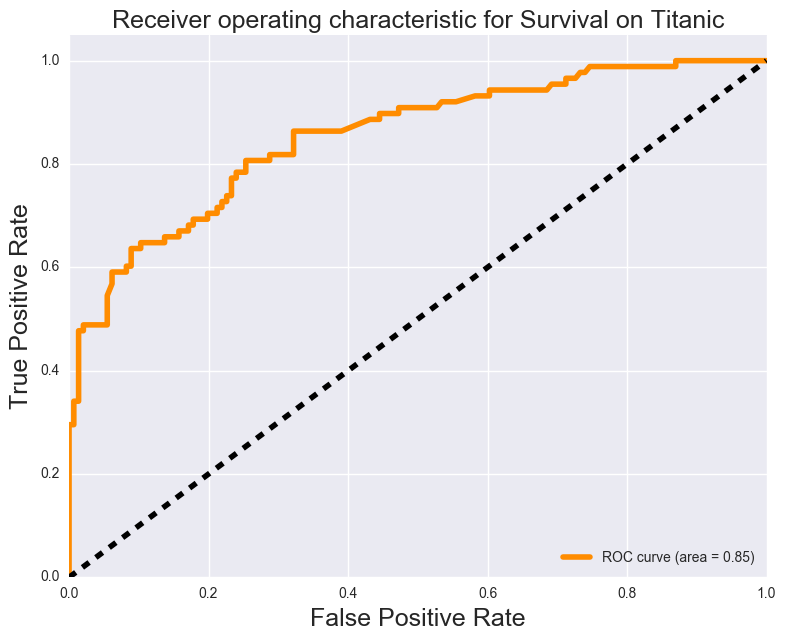

In [1545]:
""" Plot AUC"""

FPR = dict()
TPR = dict()
ROC_AUC = dict()

# For class 1, find the area under the curve
FPR[1], TPR[1], _ = roc_curve(y_test, y_score)
ROC_AUC[1] = auc(FPR[1], TPR[1])

# Plot of a ROC curve for class 1 (has_cancer)
plt.figure(figsize=[9,7])
plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4, color = 'darkorange')
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for Survival on Titanic', fontsize=18)
plt.legend(loc="lower right")
plt.show()

#### 16. What does the ROC curve tell us?

Shows the relationship between False Positive and True Positive rate. Ideal is True Positive = 1 and False Positive = 0. By changing the threshold of what would be considered 0 or 1, we can calculate the predicted classes (0 or 1). The higher the threshold, the lower number of class 1s. If the goal was to limit the False Positives, which is the number of people that were predicted to survive, but did not, then increasing the treshold would be better. Since we are prediciting survival rate, its better to predict not survive, but really survived (False Negatives), than to say survived, but did not.

#### Changing Thresholds

In [1546]:
y_pp.head()

class_0_pp  class_1_pp
0    0.269278    0.730722
1    0.657288    0.342712
2    0.547642    0.452358
3    0.439608    0.560392
4    0.875010    0.124990

In [1547]:
y_pp['survived_thresh_0.70'] = [1 if x >= 0.70 else 0 for x in y_pp.class_1_pp.values]
conmat_70 = np.array(confusion_matrix(y_test, y_pp['survived_thresh_0.70'].values))
confusion_70 = pd.DataFrame(conmat_70, index=['not survived', 'survived'],
                               columns=['not survived', 'survived'])
confusion_70

not survived  survived
not survived           144         2
survived                46        42

In [1548]:
y_pp['survived_thresh_0.80'] = [1 if x >= 0.80 else 0 for x in y_pp.class_1_pp.values]
conmat_80 = np.array(confusion_matrix(y_test, y_pp['survived_thresh_0.80'].values))
confusion_80 = pd.DataFrame(conmat_80, index=['not survived', 'survived'],
                               columns=['not survived', 'survived'])
confusion_80

not survived  survived
not survived           144         2
survived                58        30

Using probability of 0.80 gives us the lowest false positive rate. it is much better to say someone did not survive, but actually did, than saying they are alive, but really dead

## Part 5: Gridsearch

#### 1. Use GridSearchCV with logistic regression to search for optimal parameters 

- Use the provided parameter grid. Feel free to add if you like (such as n_jobs).
- Use 5-fold cross-validation.

In [1604]:
logreg_parameters = {
    'penalty':['l1','l2'],
    'C':np.logspace(-5,1,50),
    'solver':['liblinear']
}

logreg = LogisticRegression(random_state=77)

gs = GridSearchCV(logreg, n_jobs = 2,param_grid=logreg_parameters, verbose=False, cv=5)
gs.fit(X_train, y_train)


logreg = LogisticRegression(C=gs.best_params_['C'], penalty=gs.best_params_['penalty'])
cv_model = logreg.fit(X_train, y_train)
cv_pred = cv_model.predict(X_test)

#### 2. Print out the best parameters and best score. Are they better than the vanilla logistic regression?

In [1605]:
print gs.best_params_

{'penalty': 'l2', 'C': 10.0, 'solver': 'liblinear'}


In [1606]:
y_score_gs = gs.decision_function(X_test)
print 'Model Score:',cv_model.score(X_test,y_test)
print 'F1 Score   :', metrics.f1_score(y_test, cv_pred)
print classification_report(y_test,cv_pred)
print 'AUC Score:',roc_auc_score(y_test,y_score_gs)

Model Score: 0.786324786325
F1 Score   : 0.705882352941
             precision    recall  f1-score   support

          0       0.82      0.85      0.83       146
          1       0.73      0.68      0.71        88

avg / total       0.78      0.79      0.78       234

AUC Score: 0.860056039851


In [1607]:
conmat_gs = confusion_matrix(y_test, cv_pred, labels=lr.classes_)
cm_gs = pd.DataFrame(conmat_gs, columns=['not_survived','survived'], index=['not_survived','survived'])
cm_gs

not_survived  survived
not_survived           124        22
survived                28        60

#### 3. Differences between L1 and L2


L1 - Lasso: penalties constrain some coefficients to be 0 as well as reduces the weights the coefficients via the lambda parameter. This relates to sparsity, as only a small number of variables have non-zero coefficients, has more intepretability than a dense model.

L2 - Ridge: penalties reduce the weights of the coefficients by the lambda parameter

These are two methods in response to an overfitted model

#### 4. What hypothetical situations are the Ridge and Lasso penalties useful?


If there are many variables that have small/medium variables (dense model), it would be best to go with ridge because the lamba tuning parameter would cause the effects to go decrease. If there are two or more variables that are correlated, L2 will penalize both variables.

For a few features, the lasso would either reduce and/or set the coefficients of variables to 0, such that only a few variables have coefficients. The lasso is better to use on a sparse model, resulting in a few non-zero coefficients, which makes it better to interpret. If there are two or more variables that are correlated, L1 will result in one or more of the variables to be zero,and other, non-zero.

#### 3. Explain the difference between the difference between the L1 (Lasso) and L2 (Ridge) penalties on the model coefficients.

<img src="http://i.imgur.com/rLHVGtt.png" width=600>

#### 5. [BONUS] Explain how the regularization strength (C) modifies the regression loss function. Why do the Ridge and Lasso penalties have their respective effects on the coefficients?


C - is 1/alpha (or lambda), thus it is the inverse. Bigger the alpha, smaller the C. Since we are penalizing the variables/predictors, bigger the alpha (smaller C) will cause the weight of the coefficients to decrease. The loss function is minimized at the frontier of the quadratic function. From the above picture, in a L1, the weight of variable 1 (w1) is set to 0, and the weight of variable 2 (w2) is reduced. In a L2, the w1 and w2 are both reduced (both penalized). The lambda/alpha is the loss function that is the vector from the epicenter of the circle to the quadratic function

#### 6.a. [BONUS] You decide that you want to minimize false positives. Use the predicted probabilities from the model to set your threshold for labeling the positive class to need at least 90% confidence. How and why does this affect your confusion matrix?

In [1564]:
y_pp_gs = pd.DataFrame(model_lr.predict_proba(X_test), columns=['class_0_pp','class_1_pp'])
y_pp_gs['survived_thresh_0.65'] = [1 if x >= 0.65 else 0 for x in y_pp.class_1_pp.values]

conmat_90 = np.array(confusion_matrix(y_test, y_pp_gs['survived_thresh_0.65'].values))
confusion_90 = pd.DataFrame(conmat_90, index=['not survived', 'survived'],
                               columns=['not survived', 'survived'])
confusion_90

not survived  survived
not survived           142         4
survived                45        43

Changing the threshold, changes the class probabilities. This can be used if minimizing False Positives is of concern. Changing the threshold to 0.65 reduces the False Positives from 22 to 4

## Part 6: Gridsearch and kNN

#### 1. Perform Gridsearch for the same classification problem as above, but use KNeighborsClassifier as your estimator

At least have number of neighbors and weights in your parameters dictionary.

In [1608]:
knn_parameters = {
    'n_neighbors': range(1,30),
    'weights':['uniform','distance']
}

knn = KNeighborsClassifier()    
gs_k = GridSearchCV(knn,param_grid=knn_parameters , verbose=False, cv=5)
gs_k.fit(X_train, y_train)


GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=False)

#### 2. Print the best parameters and score for the gridsearched kNN model. How does it compare to the logistic regression model?

In [1609]:
print gs_k.best_params_

{'n_neighbors': 4, 'weights': 'uniform'}


#### 3. How does the number of neighbors affect the bias-variance tradeoff of your model?

#### [BONUS] Why?

as k increases, the higher the precision because it reduces noise, but it increases the bias as it looks at more points. This would be similar to having a lot more predictors in a regression scenario, where fewer the neighbors the lower the variance, but high bias. Larger the neighbors lower the bias, but higher the variance.

#### 4. In what hypothetical scenario(s) might you prefer logistic regression over kNN, aside from model performance metrics?

One would need to normalize to account for the difference in the scale of each feature. If there are a lot of features/predictors (p), logistic is better, because the ability to reduce the weights or the coefficients set to 0. If p is low, KNN might be used to select the decision boundary. It depends on the number of p, as it translates to the dimensions of the hyperplane

#### 5. Fit a new kNN model with the optimal parameters found in gridsearch. 

In [1610]:
knn = KNeighborsClassifier(n_neighbors=gs_k.best_params_['n_neighbors'], weights=gs_k.best_params_['weights'])
knn.fit(X_train,y_train)
knn_pred = knn.predict(X_test)

In [1611]:
y_pp_k = pd.DataFrame(knn.predict_proba(X_test), columns=['class_0_pp','class_1_pp'])
print 'KNN score is:',knn.score(X_test,y_test)
print 'KNN F1 score is:',metrics.f1_score(y_test,knn_pred)
print classification_report(y_test,knn_pred)
print 'AUC score is:',roc_auc_score(y_test, y_pp_k['class_1_pp'])
y_pp_k.head()

KNN score is: 0.803418803419
KNN F1 score is: 0.701298701299
             precision    recall  f1-score   support

          0       0.80      0.92      0.85       146
          1       0.82      0.61      0.70        88

avg / total       0.81      0.80      0.80       234

AUC score is: 0.850132316314


class_0_pp  class_1_pp
0        0.25        0.75
1        0.50        0.50
2        0.50        0.50
3        0.50        0.50
4        1.00        0.00

#### 6. Construct the confusion matrix for the optimal kNN model. Is it different from the logistic regression model? If so, how?

In [1612]:
conmat_k = confusion_matrix(y_test, knn_pred, labels=lr.classes_)
cm_k = pd.DataFrame(conmat_gs, columns=['not_survived','survived'], index=['not_survived','survived'])
cm_k

not_survived  survived
not_survived           124        22
survived                28        60

#### 7. [BONUS] Plot the ROC curves for the optimized logistic regression model and the optimized kNN model on the same plot.

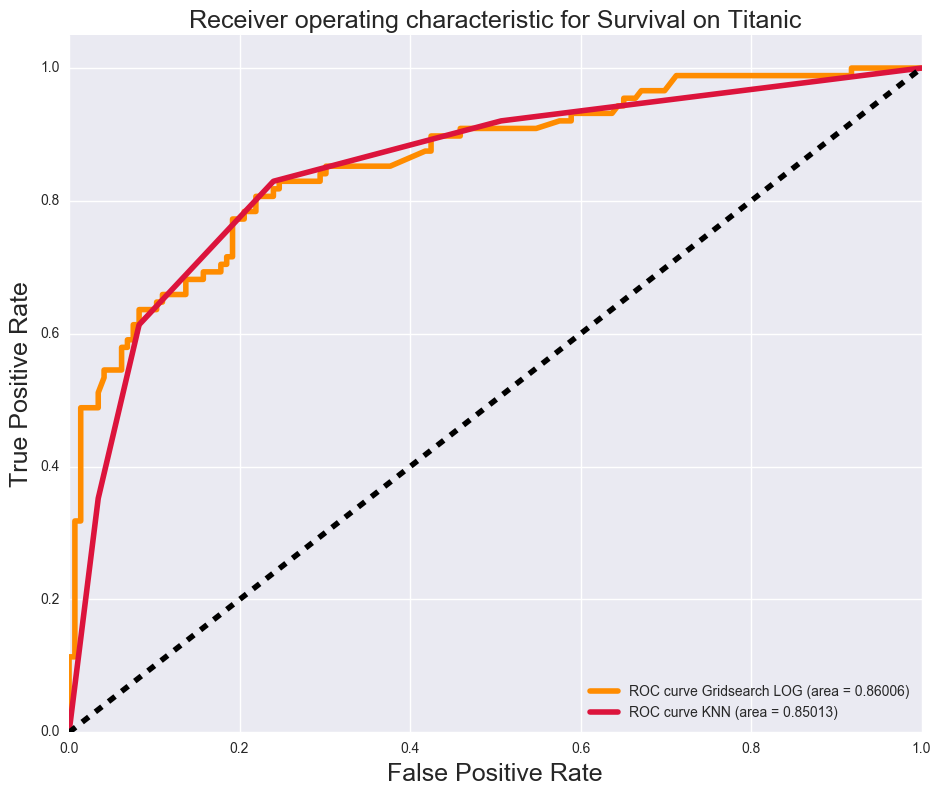

In [1570]:
""" Plot AUC"""

FPR = dict()
TPR = dict()
ROC_AUC = dict()
FPR_K = dict()
TPR_K = dict()
ROC_AUC_K = dict()

# For class 1, find the area under the curve
FPR[1], TPR[1], _ = roc_curve(y_test, y_score_gs)
FPR_K[1], TPR_K[1], _ = roc_curve(y_test,y_pp_k['class_1_pp'])
ROC_AUC[1] = auc(FPR[1], TPR[1])
ROC_AUC_K[1] = auc(FPR_K[1],TPR_K[1])

# Plot of a ROC curve for class 1 (has_cancer)
plt.figure(figsize=[11,9])
plt.plot(FPR[1], TPR[1], label='ROC curve Gridsearch LOG (area = %0.5f)' % ROC_AUC[1], linewidth=4,color = 'darkorange')
plt.plot(FPR_K[1], TPR_K[1],label='ROC curve KNN (area = %0.5f)' % ROC_AUC_K[1], linewidth=4, color = 'crimson')
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for Survival on Titanic', fontsize=18)
plt.legend(loc="lower right")
plt.show()

## Part 7: [BONUS] Precision-recall

#### 1. Gridsearch the same parameters for logistic regression but change the scoring function to 'average_precision'

`'average_precision'` will optimize parameters for area under the precision-recall curve instead of for accuracy.

In [1571]:
logreg_parameters = {
    'penalty':['l1','l2'],
    'C':np.logspace(-5,1,50),
    'solver':['liblinear']
}

logreg = LogisticRegression(solver='liblinear')

gsb = GridSearchCV(logreg, param_grid=logreg_parameters, scoring = 'average_precision',verbose=False, cv=5)
gsb.fit(X_train, y_train)


logreg = LogisticRegression(C=gs.best_params_['C'], penalty=gs.best_params_['penalty'])
cv_modelb = logreg.fit(X_train, y_train)
cv_predb = cv_modelb.predict(X_test)

print gsb.best_params_

{'penalty': 'l2', 'C': 1.0481131341546852, 'solver': 'liblinear'}


In [1599]:
print 'Gridsearch L2 Model Score:',cv_modelb.score(X_test,y_test)
print 'Gridsearch L2 F1 Score   :', metrics.f1_score(y_test, cv_predb)

Gridsearch L2 Model Score: 0.786324786325
Gridsearch L2 F1 Score   : 0.705882352941


# 2. Examine the best parameters and score. Are they different than the logistic regression gridsearch in part 5?

In [1573]:
gsb.score(X_test,y_test)
y_score_gs = gsb.decision_function(X_test)

The logistic gridsearch cv in part 5 and the gridsearch with average precision as scoring is similar. Both have the same model score and F1 score. Given that the confusion matrix is the same, the precision would also be equal.

In [1602]:
#confusion matrix for gridsearch in part 5
print 'Gridsearch L2 Model Score:',cv_model.score(X_test,y_test)
print 'Gridsearch L2 F1 Score   :', metrics.f1_score(y_test, cv_pred)
cm_gs

Gridsearch L2 Model Score: 0.786324786325
Gridsearch L2 F1 Score   : 0.705882352941


not_survived  survived
not_survived           124        22
survived                28        60

#### 3. Create the confusion matrix. Is it different than when you optimized for the accuracy? If so, why would this be?

In [1575]:
print classification_report(y_test,cv_predb)
pd.DataFrame(confusion_matrix(y_test,cv_predb),columns=['not_survived','survived'], index=['not_survived','survived'])

             precision    recall  f1-score   support

          0       0.82      0.85      0.83       146
          1       0.73      0.68      0.71        88

avg / total       0.78      0.79      0.78       234



not_survived  survived
not_survived           124        22
survived                28        60

#### 4. Plot the precision-recall curve. What does this tell us as opposed to the ROC curve?

[See the sklearn plotting example here.](http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html)

ROC curve is the probability that my predicted class is 1 given all the samples in the y actual is class 1. It is measuring True Positives vs False Positives.

Precision-Recall looks at information retreival. Precision, by definition, is the TP/ (TP + FP), that is, how well the model prediction got class 1 label correct. Recall, is the TP/(FN + TP), which is how many class 1 actuals were correct. It depends if False Positives or False Negatives are important. In this case, because its a disaster, we want to make sure we minimize the False Positives, which is the number of survived predictions given that the person actually died. 

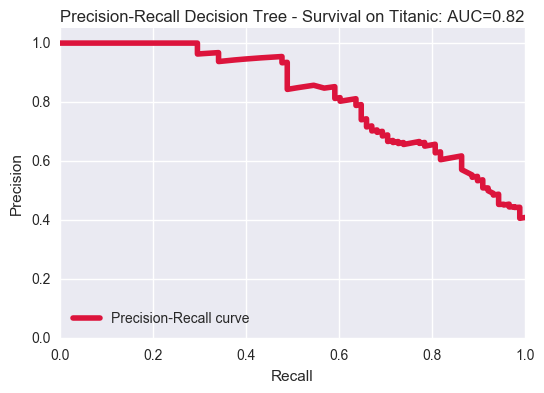

In [1576]:
#n_classes = y_test.shape[1]
# Compute Precision-Recall and plot curve
precision = dict()
recall = dict()
average_precision = dict()
#for i in range(n_classes):
precision, recall, _ = precision_recall_curve(y_test,y_score_gs)
average_precision = average_precision_score(y_test, y_score_gs)

# Plot Precision-Recall curve
plt.clf()
plt.plot(recall, precision, lw=4, color='crimson',label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Decision Tree - Survival on Titanic: AUC={0:0.2f}'.format(average_precision))
plt.legend(loc="lower left")
plt.show()

## Part 8: [VERY BONUS] Decision trees, ensembles, bagging

#### 1. Gridsearch a decision tree classifier model on the data, searching for optimal depth. Create a new decision tree model with the optimal parameters.

In [1577]:
from sklearn import tree

tree.DecisionTreeClassifier()

dtc = tree.DecisionTreeClassifier(min_samples_split=20,random_state=77)
dtc = dtc.fit(X_train, y_train)
y_pred_dtc = dtc.predict(X_test)
cross_val_score(dtc, X_test, y_test, cv=5)

array([ 0.85416667,  0.70212766,  0.72340426,  0.76086957,  0.7826087 ])

In [1578]:
print metrics.accuracy_score(y_test,y_pred_dtc)
print metrics.f1_score(y_test,y_pred_dtc)



0.820512820513
0.740740740741


#### 2. Compare the performace of the decision tree model to the logistic regression and kNN models.

In [1591]:

#Logistic Regression
print "Logistic Regression: Model score for L2:",model_lr.score(X_test, y_test)
print "Logistic Regression: F1 score for L2:",metrics.f1_score(y_test, ypred_lr)
print '\n'
#GridSearchCV
print gs.best_params_['penalty'].upper(),'GS Model Score:',cv_model.score(X_test,y_test)
print gs.best_params_['penalty'].upper(),'GS F1 Score   :', metrics.f1_score(y_test, cv_pred)
print '\n'
#KNN
print 'KNN score is:',knn.score(X_test,y_test)
print 'KNN F1 score is:',metrics.f1_score(y_test,knn_pred)
print '\n'
#Decision Tree

print 'Decision Tree score is:',dtc.score(X_test,y_test)
print 'Decision Tree F1 score is:',metrics.f1_score(y_test,y_pred_dtc)

Logistic Regression: Model score for L2: 0.782051282051
Logistic Regression: F1 score for L2: 0.690909090909


L2 GS Model Score: 0.786324786325
L2 GS F1 Score   : 0.705882352941


KNN score is: 0.803418803419
KNN F1 score is: 0.701298701299


Decision Tree score is: 0.820512820513
Decision Tree F1 score is: 0.740740740741


The decision tree classifier resulted in the best score of all the previous models used.

In [1580]:
print classification_report(y_test,y_pred_dtc)

             precision    recall  f1-score   support

          0       0.82      0.90      0.86       146
          1       0.81      0.68      0.74        88

avg / total       0.82      0.82      0.82       234



In [1581]:
#confusion matrix Logistic
cm_lr

not_survived  survived
not_survived           126        20
survived                31        57

In [1582]:
#confusion matrix gridsearch
cm_gs

not_survived  survived
not_survived           124        22
survived                28        60

In [1583]:
#confusion matrix knn
cm_k

not_survived  survived
not_survived           124        22
survived                28        60

In [1584]:
#confusion matrix Decision Tree
cm_dtc = pd.DataFrame(confusion_matrix(y_test,y_pred_dtc),columns=['not_survived','survived'], index=['not_survived','survived'])
cm_dtc

not_survived  survived
not_survived           132        14
survived                28        60

Gridsearch for Logistic and KNN yielded the same confusion matrix. Decision Tree yielded better accuracy. Type I error is lower, from 22 to 14. The Decision Tree score is better, but the AUC is a slight bit lower. Since lowering False Positives should of high concern, and the fact that the same number of survived was predicted for Gridsearch, KNN, and Decision Tree, Decision Tree would be the optimal model.

#### 3. Plot all three optimized models' ROC curves on the same plot. 

In [1587]:
y_pp_dtc = pd.DataFrame(dtc.predict_proba(X_test), columns=['class_0_pp','class_1_pp'])

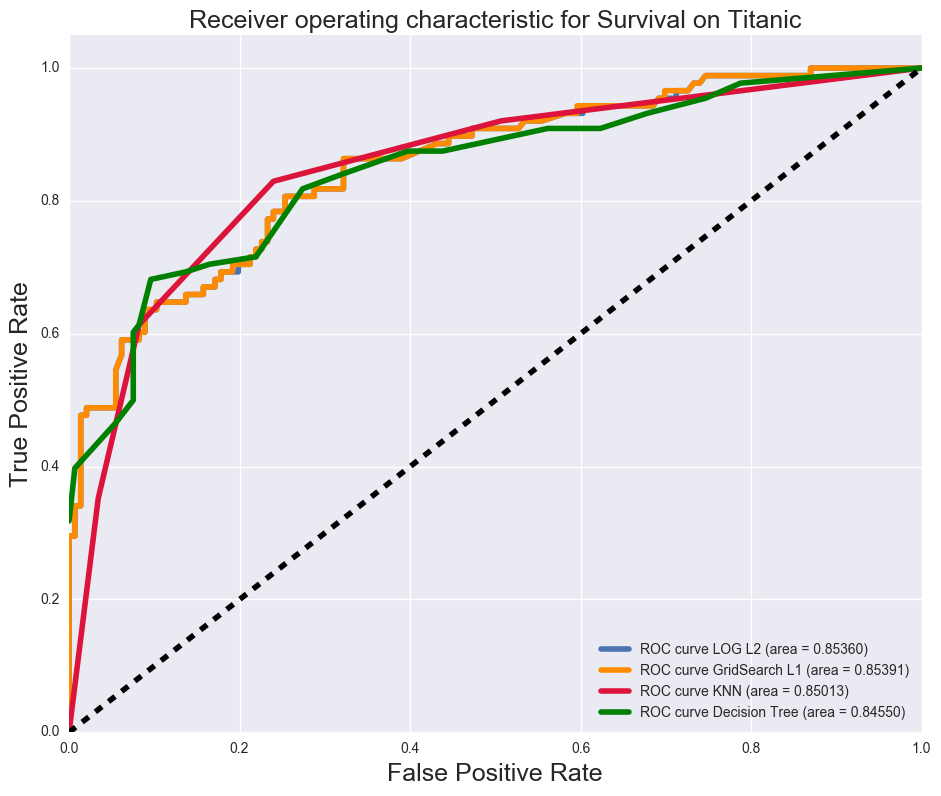

In [1588]:
""" Plot AUC"""

FPR = dict()
TPR = dict()
ROC_AUC = dict()
FPR_gs = dict()
TPR_gs = dict()
ROC_AUC_gs = dict()
FPR_K = dict()
TPR_K = dict()
ROC_AUC_K = dict()
FPR_T = dict()
TPR_T = dict()
ROC_AUC_T = dict()

# For class 1, find the area under the curve
FPR[1], TPR[1], _ = roc_curve(y_test, y_score)
FPR_gs[1], TPR_gs[1], _ = roc_curve(y_test, y_score_gs)
FPR_K[1], TPR_K[1], _ = roc_curve(y_test,y_pp_k['class_1_pp'])
FPR_T[1], TPR_T[1], _ = roc_curve(y_test,y_pp_dtc['class_1_pp'])

ROC_AUC[1] = auc(FPR[1], TPR[1])
ROC_AUC_gs[1] = auc(FPR_gs[1], TPR_gs[1])
ROC_AUC_K[1] = auc(FPR_K[1],TPR_K[1])
ROC_AUC_T[1] = auc(FPR_T[1],TPR_T[1])

# Plot of a ROC curve for class 1 (has_cancer)
plt.figure(figsize=[11,9])
plt.plot(FPR[1], TPR[1], label='ROC curve LOG L2 (area = %0.5f)' % ROC_AUC[1], linewidth=4)
plt.plot(FPR_gs[1], TPR_gs[1], label='ROC curve GridSearch L1 (area = %0.5f)' % ROC_AUC_gs[1], linewidth=4, color = 'darkorange')

plt.plot(FPR_K[1], TPR_K[1],label='ROC curve KNN (area = %0.5f)' % ROC_AUC_K[1], linewidth=4, color = 'crimson')
plt.plot(FPR_T[1], TPR_T[1],label='ROC curve Decision Tree (area = %0.5f)' % ROC_AUC_T[1], linewidth=4, color = 'green')
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for Survival on Titanic', fontsize=18)
plt.legend(loc="lower right")
plt.show()

#### 4. Use sklearn's BaggingClassifier with the base estimator your optimized decision tree model. How does the performance compare to the single decision tree classifier? 

The bagging classifer, did worse in performance than single decision tree classifier. The model score for single tree was 0.82, and for bagging classifier was .79. 

In [1589]:
bc = BaggingClassifier(base_estimator=dtc,random_state=77)
model_bc = bc.fit(X_train,y_train)
model_bc_pred = model_bc.predict(X_test)
y_pp_bc = model_bc.predict_proba(X_test)
print "Bagging Classifier score is:",model_bc.score(X_test,y_test)


Bagging Classifier score is: 0.790598290598


#### 5. Gridsearch the optimal n_estimators, max_samples, and max_features for the bagging classifier.

In [1359]:
X_train.shape[0]

473

In [1592]:
bs_parameters = {
    'n_estimators': np.arange(1,500,50),
    'max_samples': np.arange(1,400,50),
    'max_features': range(1,X_train.shape[1])
}
   
gs_bc = GridSearchCV(bc,param_grid=bs_parameters ,n_jobs = 3, verbose=False, cv=5)
gs_bc.fit(X_train, y_train)


GridSearchCV(cv=5, error_score='raise',
       estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=20, min_weight_fraction_leaf=0.0,
            presort=False, random_state=77, s..., n_estimators=10, n_jobs=1, oob_score=False,
         random_state=77, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=3,
       param_grid={'n_estimators': array([  1,  51, 101, 151, 201, 251, 301, 351, 401, 451]), 'max_samples': array([  1,  51, 101, 151, 201, 251, 301, 351]), 'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=False)

In [1593]:
gs_bc.best_params_

{'max_features': 5, 'max_samples': 351, 'n_estimators': 151}

#### 6. Create a bagging classifier model with the optimal parameters and compare it's performance to the other two models.

In [1594]:
bc_gs = BaggingClassifier(base_estimator=dtc, n_estimators=gs_bc.best_params_['n_estimators'],max_samples=gs_bc.best_params_['max_samples'], \
                       max_features=gs_bc.best_params_['max_features'],random_state=77)
model_bc_gs = bc_gs.fit(X_train,y_train)
model_bc_pred_gs = model_bc_gs.predict(X_test)
y_pp_bc_gs = model_bc_gs.predict_proba(X_test)
print "Bagging Classifier score (GS) is:",model_bc_gs.score(X_test,y_test)
print "Bagging Classifier score (GS) is:",metrics.f1_score(y_test,model_bc_pred_gs)

Bagging Classifier score (GS) is: 0.782051282051
Bagging Classifier score (GS) is: 0.666666666667


In [1595]:
print classification_report(y_test,model_bc_pred_gs)
pd.DataFrame(confusion_matrix(y_test,model_bc_pred_gs),columns=['not_survived','survived'], index=['not_survived','survived'])

             precision    recall  f1-score   support

          0       0.78      0.90      0.84       146
          1       0.78      0.58      0.67        88

avg / total       0.78      0.78      0.77       234



not_survived  survived
not_survived           132        14
survived                37        51

In [1596]:
y_pp_gs = pd.DataFrame(model_bc_gs.predict_proba(X_test), columns=['class_0_pp','class_1_pp'])
y_pp_gs.head()

class_0_pp  class_1_pp
0    0.213643    0.786357
1    0.662045    0.337955
2    0.642272    0.357728
3    0.611452    0.388548
4    0.710892    0.289108

The bagging classifier did worse than the Decision Tree, Logistic, and the KNN. The type I error (False Positive) for Decision Tree was much better, but the bagging classifier had less False Positives than the Logistic and KNN. IF the goal was to limit the number of False Positives, than this would be the second best choice.